# О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

## Подготовка данных

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [3]:
import random

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils
from torchmetrics import Accuracy
from sklearn import preprocessing
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder

In [4]:
# %conda install wget

In [5]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-03-21 13:43:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [       <=>          ] 201.24M  40.1MB/s    in 5.5s    

2024-03-21 13:43:23 (36.9 MB/s) - ‘data.txt.zip’ saved [211011981]



In [6]:
df = pd.read_csv("data.txt.zip", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Разобьем данные на обучение и тест

In [7]:
X = df.iloc[:, 1:].values # срез по индексам строк и столбцов
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]
X_train.shape, X_test.shape

((463715, 90), (51630, 90))

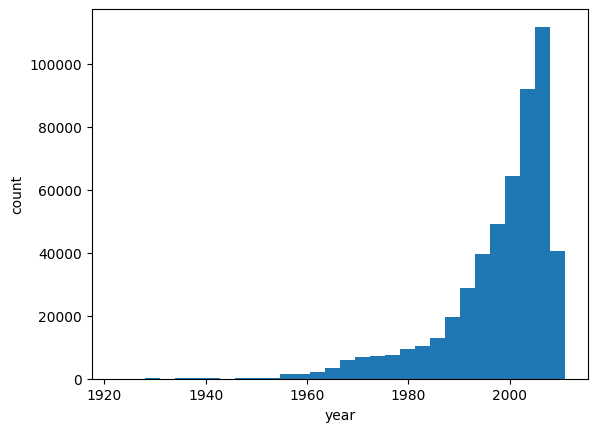

In [8]:
plt.hist(y, bins=30)
plt.xlabel('year')
plt.ylabel('count')
plt.show()
# в данных в основном у нас 2000 год, ненормированно

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Прежде чем обучать нейронные сети, нам нужно проверить несколько простых бейзлайнов, чтобы было с чем сравнить более сложные алгоритмы и посмотреть удалось ли нам побить бейзлайн (регрессия или классификация?)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_test_pred = ridge.predict(X_test)
print("Ridge", mean_squared_error(y_test, y_test_pred, squared=False))

Ridge 9.510160711373397


In [10]:
best_const = np.mean((y_train))
y_const = [best_const] * len(y_test)
print("Best const", mean_squared_error(y_test, y_const, squared=False))

Best const 10.85246390513634


In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe_ridge = make_pipeline(StandardScaler(), Ridge())
pipe_ridge.fit(X_train, y_train)
y_pred_train = pipe_ridge.predict(X_train)
y_pred_test = pipe_ridge.predict(X_test)

print('Test RMSE:', mean_squared_error(y_pred_test, y_test, squared=False), '\nTrain RMSE: ', mean_squared_error(y_pred_train, y_train, squared=False))

Test RMSE: 9.510160820470436 
Train RMSE:  9.552822967970322


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [12]:
INPUT_SIZE = 90
HIDDEN_SIZE = 120
OUTPUT_SIZE = 1 # наша задача регрессия, мы выводим лишь одно значение — год
LEARNING_RATE = 1e-2
EPOCHS = 4
BATCH_SIZE = 48

In [13]:
#  классы в нашем примере несбалансированы, поэтому стоит нормировать данные.
#  Начнем с того, что попробуем отнормировать целевую переменную. Для этого воспользуемся min-max нормализацией, чтобы целевая переменная принимала значения от 0 до 1.
# Реализуем функции normalize и denormalize, которые, соответственно, нормируют целевую переменную и применяют обратное преобразование.

min_ = min(y_train)
max_ = max(y_train)

# sample - это обьект массива, тензора
# нормализация: у нас есть два года 2000 и 1911 -> 2000 - 1911 = 98 / 100 = 0,89
# денормализация: 0,89 * 100 = 89 + 1911 = 2000

def normalize(sample):
    return (sample - min_) / (max_ - min_)

def denormalize(sample):
    return (sample * (max_ - min_) + min_).to(torch.float32)

In [14]:
class NN_Model(nn.Module):
    def __init__(self, in_features, out_features, hidden_size):
        super().__init__()
        self.model = nn.Sequential(  # специальный контейнер Sequential для последовательного наслоения
            nn.Linear(in_features=in_features, out_features=hidden_size), # первый слой
            nn.ReLU(), # ф. активации
            nn.Linear(in_features=hidden_size, out_features=out_features), # второй слой
            nn.Sigmoid() # ф. активации
        )

    def forward(self, x): # определяем forward метод в нашем классе, целью которого является определить порядок, в котором входные данные проходят через наши слои
        return self.model(x)

In [15]:
model = NN_Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE) # инициализация нашей модели
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE) # стохастический градиентный спуск в качестве оптимизатора
criterion = nn.MSELoss() # среднеквадратическая ошибка в качестве функции потерь
metricMSE = lambda y_pred, y_true: nn.MSELoss()(denormalize(y_pred), denormalize(y_true))

In [16]:
model

NN_Model(
  (model): Sequential(
    (0): Linear(in_features=90, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [17]:
for name, param in model.named_parameters():
  print(name, param)

model.0.weight Parameter containing:
tensor([[ 0.0484, -0.0748, -0.0357,  ...,  0.0013, -0.0265,  0.0785],
        [ 0.1043, -0.0504,  0.0954,  ..., -0.0163,  0.0928,  0.0340],
        [ 0.0979, -0.0240,  0.0550,  ...,  0.0337, -0.0216, -0.0340],
        ...,
        [ 0.1052,  0.0665, -0.1046,  ..., -0.0708, -0.0297, -0.0739],
        [ 0.0042,  0.0895, -0.0554,  ...,  0.0648,  0.0779,  0.0163],
        [ 0.0604,  0.0613, -0.0043,  ...,  0.0907, -0.0150, -0.0552]],
       requires_grad=True)
model.0.bias Parameter containing:
tensor([-0.0661,  0.0463,  0.0196, -0.0971,  0.0337,  0.0780, -0.0926, -0.0650,
        -0.0376,  0.0766,  0.0750,  0.0545, -0.0670, -0.0111, -0.0526, -0.0972,
         0.0698, -0.0158,  0.0327,  0.0216,  0.0911,  0.0858,  0.0926,  0.0367,
         0.0406, -0.0867, -0.0307, -0.0427,  0.0634, -0.0512,  0.0384,  0.0618,
         0.0847,  0.0040,  0.0422, -0.0989,  0.0447, -0.0055, -0.0099, -0.0827,
        -0.0294, -0.0288, -0.0516,  0.0329, -0.0036, -0.0759, -0.09

In [14]:
# Подготовим загрузчик данных
def create_data_loader(X, y, shuffle = False):
    X = torch.tensor(X.astype(np.float32))
    y = torch.from_numpy(y).to(torch.float32).reshape(-1, 1)

    tensor = data_utils.TensorDataset(X, normalize(y)) # нормалайз для каждого обьекта в тензоре вызывает эту функцию
    loader = data_utils.DataLoader(dataset=tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=shuffle)

    return loader

In [15]:
train_loader = create_data_loader(X_train, y_train, True) # torch.utils.data.Dataloader with train set
test_loader = create_data_loader(X_test, y_test) # torch.utils.data.Dataloader with test set

In [16]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [18]:
# матрица
# в иксе у нас в каждой строке по 90 чиcел. в у (см ниже) 1, то есть те самые входной и выходной слои
# огрубляя, с этими матрицами мы будем перемножать веса и отклонения
# тут виден и batch-size - 48 строк
X

array([[ 4.994357e+01,  2.147114e+01,  7.307750e+01, ..., -1.822230e+00,
        -2.746348e+01,  2.263270e+00],
       [ 4.873215e+01,  1.842930e+01,  7.032679e+01, ...,  1.204941e+01,
         5.843453e+01,  2.692061e+01],
       [ 5.095714e+01,  3.185602e+01,  5.581851e+01, ..., -5.859000e-02,
         3.967068e+01, -6.634500e-01],
       ...,
       [ 4.512852e+01,  1.265758e+01, -3.872018e+01, ..., -6.071710e+00,
         5.396319e+01, -8.093640e+00],
       [ 4.416614e+01,  3.238368e+01, -3.349710e+00, ...,  2.032240e+01,
         1.483107e+01,  3.974909e+01],
       [ 5.185726e+01,  5.911655e+01,  2.639436e+01, ..., -5.515120e+00,
         3.235602e+01,  1.217352e+01]])

In [19]:
y

array([2001, 2001, 2001, ..., 2006, 2006, 2005])

In [49]:
model

NN_Model(
  (model): Sequential(
    (0): Linear(in_features=90, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('RMSE')
    plt.show()

In [22]:
import math

train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def train(model, optimizer, criterion, metricMSE, train_loader, test_loader, epoch = -1):

  """
  params:
      model - torch.nn.Module to be fitted
      optimizer - model optimizer
      criterion - loss function from torch.nn
      train_loader - torch.utils.data.Dataloader with train set
      test_loader - torch.utils.data.Dataloader with test set
                    (if you wish to validate during training)
  """


  model.train() # устанавливаем режим обучения модели
  running_loss = 0
  running_acc = 0
  for features, label in tqdm(train_loader):
      features = features.to(device) # приводим под наш девайс
      label = label.to(device)

      # Reset gradients - мы устанавливаем градиенты равными нулю перед каждым обновлением, используя функцию optimizer.zero_grad()
      optimizer.zero_grad()

      # Forward pass - при прямом проходе мы делаем прогнозы, используя нашу модель, и рассчитываем потери на основе этих прогнозов и наших фактических меток
      output = model(features)
      loss = criterion(output, label) # Calculate error and backpropagate (метод обратного распространения ошибки)

      # Backward and optimize - Затем мы выполняем обратный проход, где фактически обновляем наши веса, чтобы улучшить нашу модель
      loss.backward() # мы вычисляем новые градиенты, используя функцию loss.backward()
      optimizer.step() # обновляем веса с помощью функции optimizer.step()

      with torch.no_grad(): # Мы помещаем код внутрь torch.no_grad(), поскольку нет необходимости вычислять какие-либо градиенты.
                            # Затем мы прогнозируем каждую партию, используя нашу модель, и вычисляем, сколько она предсказывает правильно.
          metric_value =  math.sqrt(metricMSE(output, label))
          if type(metric_value) == torch.Tensor:
              metric_value = metric_value.item()
          running_loss += loss.item() * features.shape[0]
          running_acc += metric_value * features.shape[0]

  train_loss_values.append(running_loss / len(train_loader.dataset))
  train_accuracy_values.append(running_acc / len(train_loader.dataset))
  if epoch % 2 == 0:
      print(f'EPOCH {epoch}: train_loss: {train_loss_values[-1]} train_acc: {train_accuracy_values[-1]}')

  return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy



def test(model, criterion, metricMSE, test_loader, epoch = -1):

  """
  params:
      model - torch.nn.Module to be evaluated on test set
      criterion - loss function from torch.nn
      test_loader - torch.utils.data.Dataloader with test set
  ----------
  returns:
      predicts - torch.tensor with shape (len(test_loader.dataset), ),
                  which contains predictions for test objects
  """

  model.eval() # устанавливаем режим теста модели
  running_loss = 0
  running_acc = 0
  for features, label in test_loader:
      output = model(features)  # приводим тензоры под над девайс

      loss = criterion(output, label)  # Calculate error and backpropagate (метод обратного распространения ошибки)

      with torch.no_grad(): # Мы помещаем код внутрь torch.no_grad(), поскольку нет необходимости вычислять какие-либо градиенты.
                            # Затем мы прогнозируем каждую партию, используя нашу модель, и вычисляем, сколько она предсказывает правильно.
          metric_value =  math.sqrt(metricMSE(output, label))
          if type(metric_value) == torch.Tensor:
              metric_value = metric_value.item()
          running_loss += loss.item() * features.shape[0]
          running_acc += metric_value * features.shape[0]

  plot_losses(train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy)
  valid_loss_values.append(running_loss / len(test_loader.dataset))
  valid_accuracy.append(running_acc / len(test_loader.dataset))
  if epoch % 2 == 0:
        print(f'EPOCH {epoch}: valid_loss: {valid_loss_values[-1]} valid_acc: {valid_accuracy[-1]}')

  predicts = torch.ones(len(test_loader.dataset)) # torch.tensor with shape (len(test_loader.dataset), ), which contains predictions for test objects

  return predicts

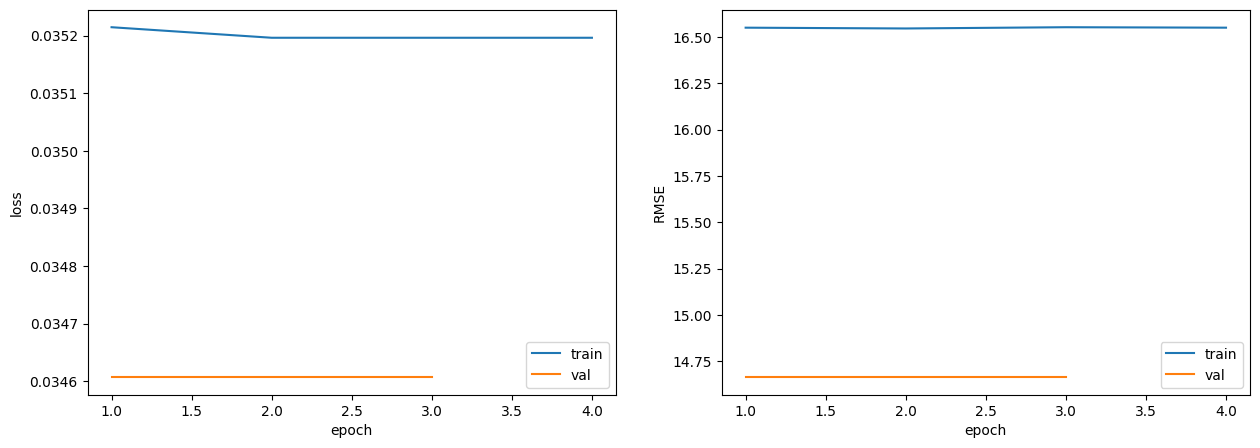

In [23]:
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

for epoch in range(EPOCHS):  # пробегаемся по эпохам и вызываем train и test
  train(model, optimizer, criterion, metricMSE, train_loader, test_loader, epoch)
  test(model, criterion, metricMSE, test_loader, epoch)

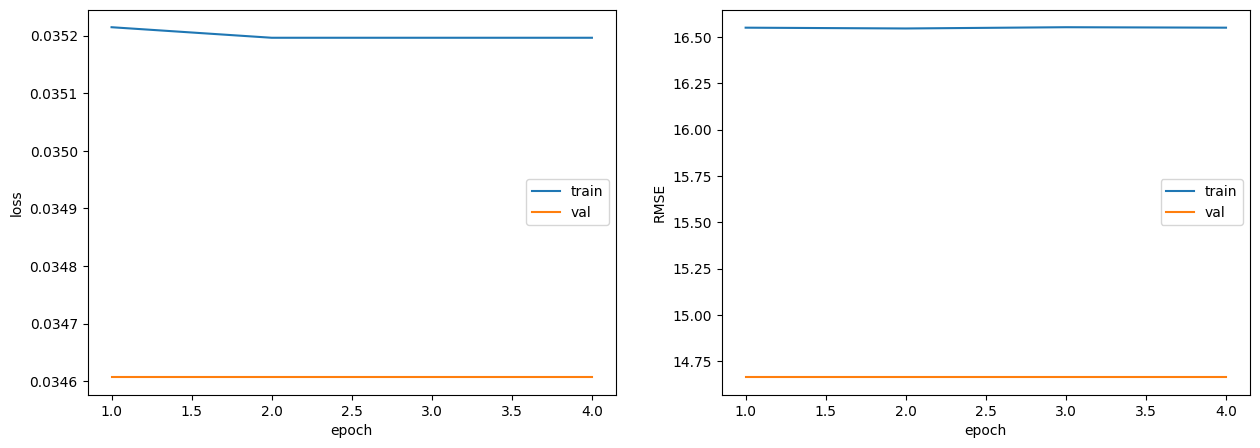

In [24]:
assert test(model, criterion, metricMSE, test_loader).shape[0] == y_test.shape[0]

**После второй эпохи ошибка стала константной, значит тут что-то не так.


## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

### Попытка 1: Изменение оптимизатора, скорости обучения и добавление стандартизации


---


In [25]:
INPUT_SIZE = 90
HIDDEN_SIZE = 120
OUTPUT_SIZE = 1
LEARNING_RATE = 1e-2
EPOCHS = 4
BATCH_SIZE = 48

In [26]:
# Попробуем отнормировать не только целевую переменную, но и сами данные, которые подаются сети на вход. Для них будем использовать нормализацию через среднее и стандартное отклонение.
from sklearn.preprocessing import StandardScaler

def create_data_loader(X, y, shuffle = False):
    sc = StandardScaler()
    X_sc = sc.fit_transform(X)
    X = torch.tensor(X_sc.astype(np.float32))
    y = torch.from_numpy(y).to(torch.float32).reshape(-1, 1)

    tensor = data_utils.TensorDataset(X, normalize(y))
    loader = data_utils.DataLoader(dataset=tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=shuffle)

    return loader

In [27]:
train_loader = create_data_loader(X_train, y_train, True) # torch.utils.data.Dataloader with train set
test_loader = create_data_loader(X_test, y_test) # torch.utils.data.Dataloader with test set

In [28]:
# Для Adam обычно берут learning rate поменьше, изменим:
LEARNING_RATE = 1e-3

In [29]:
model_1 = NN_Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE)
optimizer_adam = torch.optim.Adam(model_1.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
metricMSE = lambda y_pred, y_true: nn.MSELoss()(denormalize(y_pred), denormalize(y_true))

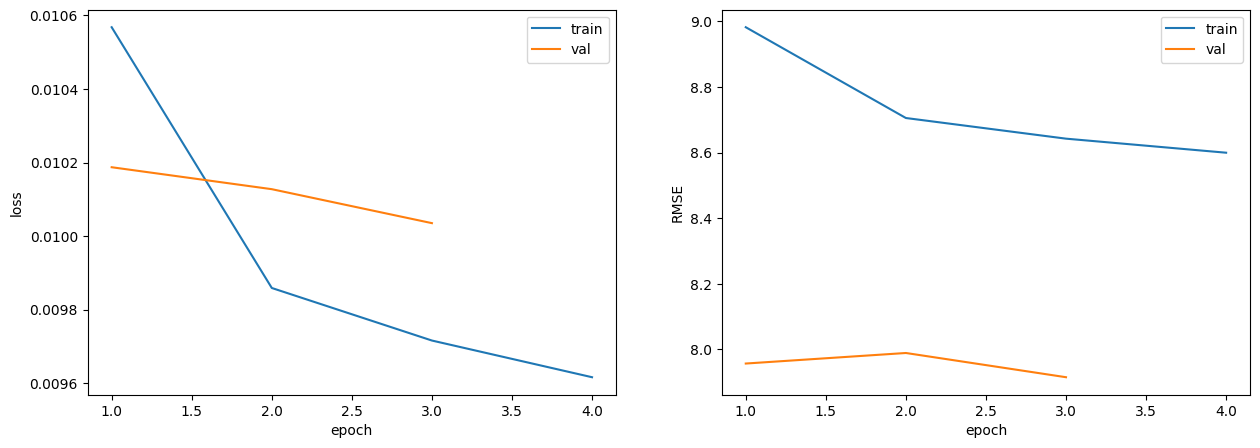

In [30]:
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

for epoch in range(EPOCHS):  # пробегаемся по эпохам и вызываем train и test
  train(model_1, optimizer_adam, criterion, metricMSE, train_loader, test_loader, epoch)
  test(model_1, criterion, metricMSE, test_loader, epoch)

### Попытка 2: Увеличение размера скрытого слоя

---

сделаем НС более широкой (то есть увеличим размерность скрытого слоя, например, вдвое)

In [31]:
HIDDEN_SIZE = 240

In [32]:
model_2 = NN_Model(INPUT_SIZE, OUTPUT_SIZE, 240)
optimizer_adam = torch.optim.Adam(model_2.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
metricMSE = lambda y_pred, y_true: nn.MSELoss()(denormalize(y_pred), denormalize(y_true))

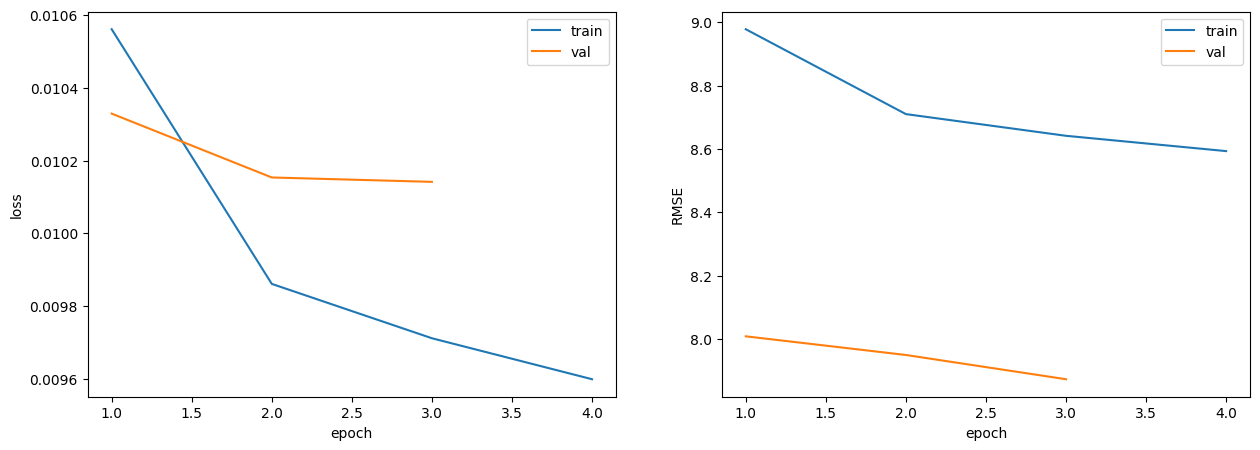

In [33]:
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

for epoch in range(EPOCHS): # пробегаемся по эпохам и вызываем train и test
  train(model_2, optimizer_adam, criterion, metricMSE, train_loader, test_loader, epoch)
  test(model_2, criterion, metricMSE, test_loader, epoch)

### Попытка 3: Увеличение количества слоев нейронной сети

---


сделаем НС более глубокой (то есть добавим еще один скрытый слой)

In [34]:
class NN_Model2(nn.Module):
    def __init__(self, in_features, out_features, hidden_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_size), # первый слой
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size), # второй слой
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=out_features), # третий слой добавили
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [35]:
model_3 = NN_Model2(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE)
optimizer_adam = torch.optim.Adam(model_3.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
metricMSE = lambda y_pred, y_true: nn.MSELoss()(denormalize(y_pred), denormalize(y_true))

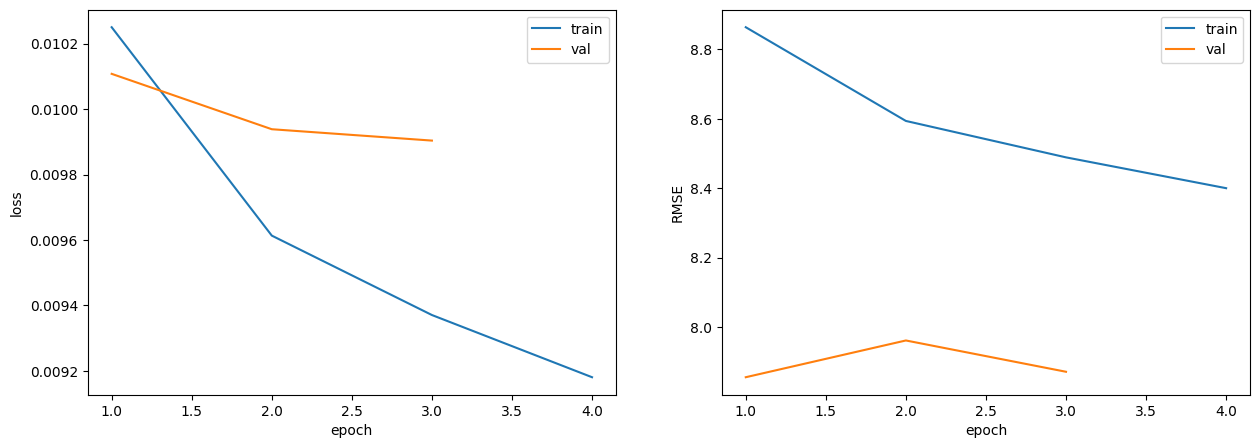

In [36]:
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

for epoch in range(EPOCHS):  # пробегаемся по эпохам и вызываем train и test
  train(model_3, optimizer_adam, criterion, metricMSE, train_loader, test_loader, epoch)
  test(model_3, criterion, metricMSE, test_loader, epoch)

**Ошибка стала немного больше, что говорит о переобучении.**

### Попытка 4: Работа над переобучением

---

Более сложная модель стала сильнее переобучаться. Попробуем добавить в обучение регуляризацию, чтобы бороться с переобучением. Добавим слой дропаута


In [37]:
class NN_Model3(nn.Module):
    def __init__(self, in_features, out_features, hidden_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_size),
            nn.Dropout(p=0.4), # дропаут
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.Dropout(p=0.2), # дропаут
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [38]:
model_4 = NN_Model3(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE)
optimizer_adam = torch.optim.Adam(model_4.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
metricMSE = lambda y_pred, y_true: nn.MSELoss()(denormalize(y_pred), denormalize(y_true))

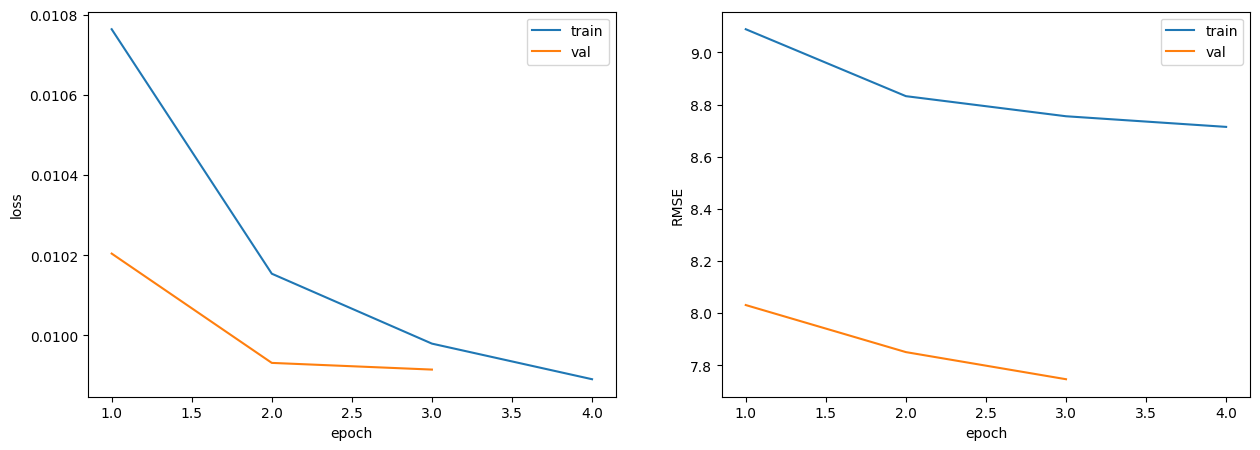

In [39]:
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

for epoch in range(EPOCHS):  # пробегаемся по эпохам и вызываем train и test
  train(model_4, optimizer_adam, criterion, metricMSE, train_loader, test_loader, epoch)
  test(model_4, criterion, metricMSE, test_loader, epoch)

**Стало немного лучше. Дропаут помогает помогает избежать переобучения. Ошибка уменьшилась.**